# PPO Third Implementation
https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/

In [202]:
import argparse
import os
import random
import time
from distutils.util import strtobool

# import gym
from gridworld_ctf_mvp import GridworldCtf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
# from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [217]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        self.network = nn.Sequential(
            layer_init(nn.Linear(192, 256)),
            nn.Tanh(),
            layer_init(nn.Linear(256, 128)),
            nn.Tanh(),
        )
        self.actor = layer_init(nn.Linear(128, 4), std=0.01)
        self.critic = layer_init(nn.Linear(128, 1), std=1)

    def get_value(self, x1, x2):
        x1 = x1.view(x1.shape[0], 180)
        x = torch.concat((x1, x2), dim=1)
        return self.critic(self.network(x))

    def get_action_and_value(self, x1, x2, action=None):
        x1 = x1.view(x1.shape[0], 180)
        x = torch.concat((x1, x2), dim=1)
        hidden = self.network(x)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)

In [225]:
class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        self.conv1 = nn.Conv2d(5, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(32*2*2 + 12, 256)
        self.action_head = nn.Linear(256, 4)
        self.value_head = nn.Linear(256, 1)

    def get_value(self, x, x2):
        x = torch.tanh(self.conv1(x))        
        x = torch.tanh(self.conv2(x))        
        x = x.view(-1, 32*2*2)

        # Add in metadata
        x = torch.concat((x, x2), dim=1)

        x = torch.tanh(self.fc1(x))        
        return self.value_head(x)

    def get_action_and_value(self, x, x2, action=None):
        x = torch.tanh(self.conv1(x))        
        x = torch.tanh(self.conv2(x))        
        x = x.view(-1, 32*2*2)

        # Add in metadata
        x = torch.concat((x, x2), dim=1)

        x = torch.tanh(self.fc1(x))        
        logits = self.action_head(x)

        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.value_head(x)


In [226]:
agent = Agent()

config = {
            'GAME_MODE':'static',
            'GRID_SIZE':6,
            'AGENT_CONFIG':{
                0: {'team':0, 'type':0},
                1: {'team':1, 'type':0}
            },
            'DROP_FLAG_WHEN_NO_HP':False,
            'GLOBAL_REWARDS': False
        }

env = GridworldCtf(**config)


x1 = torch.tensor(env.standardise_state(0, use_ego_state=True), dtype=torch.float32)
x2 = torch.tensor(env.get_env_metadata_local(0), dtype=torch.float32)

print(x1.shape)
print(x2.shape)

x1 = torch.randn((3, 5, 6, 6))
x2 = torch.randn((3, 12))

print(x1.shape)
print(x2.shape)

val = agent.get_value(x1, x2)
action, probs, entropy, val2 = agent.get_action_and_value(x1, x2)

print(val)
print(action, probs, entropy, val2)


torch.Size([1, 5, 6, 6])
torch.Size([1, 12])
torch.Size([3, 5, 6, 6])
torch.Size([3, 12])
tensor([[-0.1515],
        [ 0.0236],
        [-0.0241]], grad_fn=<AddmmBackward0>)
tensor([2, 0, 2]) tensor([-1.3552, -1.2896, -1.2604], grad_fn=<SqueezeBackward1>) tensor([1.3843, 1.3830, 1.3777], grad_fn=<NegBackward0>) tensor([[-0.1515],
        [ 0.0236],
        [-0.0241]], grad_fn=<AddmmBackward0>)


In [227]:
class PPOConfig():
    def __init__(self):
        self.exp_name = "PPO test"
        self.gym_id = "CartPole-v1"
        self.learning_rate = 0.0003
        self.seed = 1
        self.total_timesteps = 100000
        self.torch_deterministic = True
        self.cuda = True
        self.track = False
        self.wandb_project_name = "ppo-implementation-details"
        self.wandb_entity = None
        self.capture_video = False
        self.num_envs = 1
        self.num_steps = 256
        self.anneal_lr = False
        self.gae = True
        self.gamma = 0.96
        self.gae_lambda = 0.95
        self.num_minibatches = 4
        self.update_epochs = 4
        self.norm_adv = False
        self.clip_coef = 0.2
        self.clip_vloss = True
        self.ent_coef = 0.01
        self.vf_coef = 0.5
        self.max_grad_norm = 0.5
        self.target_kl = None
        self.batch_size = int(self.num_envs * self.num_steps)
        self.minibatch_size = int(self.batch_size // self.num_minibatches)

args = PPOConfig()

In [228]:
run_name = "Run"

if args.track:
    import wandb

    wandb.init(
        project=args.wandb_project_name,
        entity=args.wandb_entity,
        sync_tensorboard=True,
        config=vars(args),
        name=run_name,
        monitor_gym=True,
        save_code=True,
    )

# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

agent = Agent().to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)

# ALGO Logic: Storage setup
obs = torch.zeros((args.num_steps, 5, 6, 6)).to(device)
obs2 = torch.zeros((args.num_steps, 12)).to(device)
actions = torch.zeros((args.num_steps, )).to(device)
logprobs = torch.zeros((args.num_steps, )).to(device)
rewards = torch.zeros((args.num_steps, )).to(device)
dones = torch.zeros((args.num_steps, )).to(device)
values = torch.zeros((args.num_steps, )).to(device)

# Environment setup
config = {
            'GAME_MODE':'static',
            'GRID_SIZE':6,
            'AGENT_CONFIG':{
                0: {'team':0, 'type':0},
                1: {'team':1, 'type':0}
            },
            'DROP_FLAG_WHEN_NO_HP':False,
            'GLOBAL_REWARDS': False
        }

env = GridworldCtf(**config)
# env.AGENT_TYPE_DAMAGE = {
#     0: 0,
#     1: 0,
#     2: 0
# }
env.WINNING_POINTS = 100
env.reset()

# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs = torch.tensor(env.standardise_state(0, use_ego_state=True), dtype=torch.float32).to(device)
next_obs2 = torch.tensor(env.get_env_metadata_local(0), dtype=torch.float32).to(device)
next_done = torch.zeros(args.num_envs).to(device)
num_updates = args.total_timesteps // args.batch_size

max_rewards = -np.inf
total_rewards = []

#----------------------------------------------------------------------
# Training Loop Start
#----------------------------------------------------------------------
for update in range(1, num_updates + 1):
    # Annealing the rate if instructed to do so.
    if args.anneal_lr:
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * args.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    #----------------------------------------------------------------------
    # Get rollout
    #----------------------------------------------------------------------
    for step in range(0, args.num_steps):
        global_step += 1 * args.num_envs
        obs[step] = next_obs
        obs2[step] = next_obs2
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs, next_obs2)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # Opponent action
        opp_action = torch.randint(low=0, high=4, size=(1,)).item()

        actions2 = [action, opp_action]

        # TRY NOT TO MODIFY: execute the game and log data.
        _, reward, done = env.step(actions2)
        next_obs = torch.tensor(env.standardise_state(0, use_ego_state=True), dtype=torch.float32).to(device)
        next_obs2 = torch.tensor(env.get_env_metadata_local(0), dtype=torch.float32).to(device)

        done2 = 1 if done else 0 

        rewards[step] = torch.tensor([reward[0]]).to(device).view(-1)
        next_done = torch.Tensor([done2]).to(device)

        if rewards.sum().item() > max_rewards:
            max_rewards = rewards.sum().item()

    env.reset()
    next_obs = torch.tensor(env.standardise_state(0, use_ego_state=True), dtype=torch.float32).to(device)
    next_obs2 = torch.tensor(env.get_env_metadata_local(0), dtype=torch.float32).to(device)
    next_done = torch.zeros(args.num_envs).to(device)

    #----------------------------------------------------------------------
    # Calculate Advantages
    #----------------------------------------------------------------------
    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs, next_obs2).reshape(1, -1)
        if args.gae:
            advantages = torch.zeros_like(rewards).to(device)
            lastgaelam = 0
            for t in reversed(range(args.num_steps)):
                if t == args.num_steps - 1:
                    nextnonterminal = 1.0 - next_done
                    nextvalues = next_value
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    nextvalues = values[t + 1]
                delta = rewards[t] + args.gamma * nextvalues * nextnonterminal - values[t]
                advantages[t] = lastgaelam = delta + args.gamma * args.gae_lambda * nextnonterminal * lastgaelam
            returns = advantages + values
        else:
            returns = torch.zeros_like(rewards).to(device)
            for t in reversed(range(args.num_steps)):
                if t == args.num_steps - 1:
                    nextnonterminal = 1.0 - next_done
                    next_return = next_value
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    next_return = returns[t + 1]
                returns[t] = rewards[t] + args.gamma * nextnonterminal * next_return
            advantages = returns - values

    #----------------------------------------------------------------------
    # Update Policy 
    #----------------------------------------------------------------------
    
    # flatten the batch
    b_obs = obs.reshape((-1,) + (5, 6, 6))
    b_obs2 = obs2.reshape((-1,) + (12,))
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape(-1,)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Check shapes
    # print('obs:', obs.shape, b_obs.shape)
    # print('obs2:', obs2.shape, b_obs2.shape)
    # print('log probs:', logprobs.shape, b_logprobs.shape)
    # print('actions:', actions.shape, b_actions.shape)
    # print('advantages:', advantages.shape, b_advantages.shape)
    # print('returns:', returns.shape, b_returns.shape)
    # print('values:', values.shape, b_values.shape)
    # print(breakit)

    # Optimizing the policy and value network
    b_inds = np.arange(args.batch_size)
    clipfracs = []
    for epoch in range(args.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, args.batch_size, args.minibatch_size):
            end = start + args.minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_obs2[mb_inds], b_actions.long()[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > args.clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if args.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - args.clip_coef, 1 + args.clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if args.clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -args.clip_coef,
                    args.clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - args.ent_coef * entropy_loss + v_loss * args.vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
            optimizer.step()

        if args.target_kl is not None:
            if approx_kl > args.target_kl:
                break

    #----------------------------------------------------------------------
    # Logging
    #----------------------------------------------------------------------
    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    total_rewards.append(rewards.sum())
    average_rewards = round(np.mean(total_rewards[-50:]), 2)

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    # clear_output()
    print(f'i: {update}\t', 
            f'ar: {"{:0.4f}".format(average_rewards)}\t',
            f'mx: {max_rewards}\t', 
            f'lr: {round(optimizer.param_groups[0]["lr"], 6)}\t', 
            f'vl: {round(v_loss.item(), 4)}\t',
            f'pl: {round(pg_loss.item(), 4)}\t', 
            f'ent: {round(entropy_loss.item(), 4)}\t')
    # writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    # writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    # writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    # writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    # writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    # writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    # writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    # writer.add_scalar("losses/explained_variance", explained_var, global_step)
    # print("SPS:", int(global_step / (time.time() - start_time)))
    # writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)
print('Complete')


i: 1	 ar: -256.0000	 mx: -1.0	 lr: 0.0003	 vl: 58.7665	 pl: 10.9257	 ent: 1.3779	
i: 2	 ar: -206.0000	 mx: -1.0	 lr: 0.0003	 vl: 193.9944	 pl: 4.9901	 ent: 1.3591	
i: 3	 ar: -222.6700	 mx: -1.0	 lr: 0.0003	 vl: 55.5358	 pl: 10.7458	 ent: 1.3339	
i: 4	 ar: -231.0000	 mx: -1.0	 lr: 0.0003	 vl: 52.2555	 pl: 10.1626	 ent: 1.3292	
i: 5	 ar: -236.0000	 mx: -1.0	 lr: 0.0003	 vl: 48.4821	 pl: 9.9371	 ent: 1.3504	
i: 6	 ar: -239.3300	 mx: -1.0	 lr: 0.0003	 vl: 48.2739	 pl: 9.8382	 ent: 1.3739	
i: 7	 ar: -241.7100	 mx: -1.0	 lr: 0.0003	 vl: 44.7952	 pl: 9.4198	 ent: 1.3585	
i: 8	 ar: -218.5000	 mx: -1.0	 lr: 0.0003	 vl: 237.5305	 pl: -0.3476	 ent: 1.3167	
i: 9	 ar: -222.6700	 mx: -1.0	 lr: 0.0003	 vl: 38.2176	 pl: 8.9824	 ent: 1.3417	
i: 10	 ar: -216.0000	 mx: -1.0	 lr: 0.0003	 vl: 64.454	 pl: 5.3765	 ent: 1.3485	
i: 11	 ar: -219.6400	 mx: -1.0	 lr: 0.0003	 vl: 36.8687	 pl: 8.8332	 ent: 1.3141	
i: 12	 ar: -222.6700	 mx: -1.0	 lr: 0.0003	 vl: 35.4964	 pl: 8.5273	 ent: 1.2309	
i: 13	 ar: -225.2300

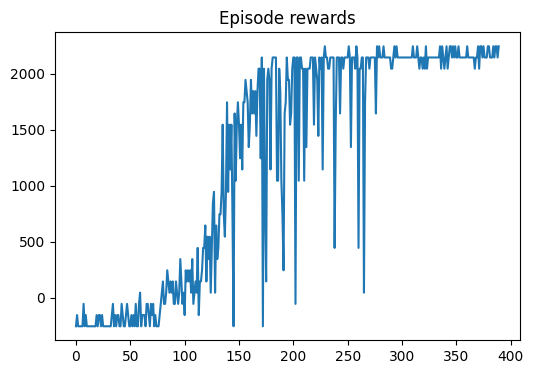

In [229]:
# Plot rewards
plt.figure(figsize=(6, 4))
plt.title('Episode rewards')
plt.plot(total_rewards)
plt.show()

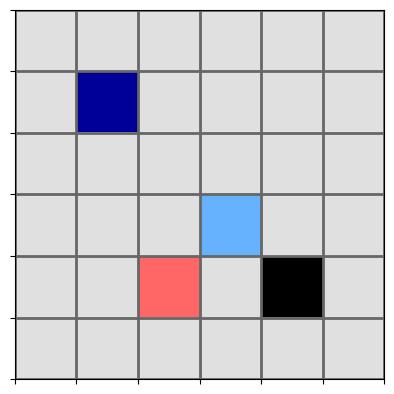

129 -1 1071


In [233]:
max_steps = 128
step_count = 0
done= False
device = 'cpu'
env.reset()
total_rewards = 0
while not done:
    step_count += 1

    actions = []
    for agent_idx in np.arange(env.N_AGENTS):
        # Get global and local states
        grid_state = torch.tensor(env.standardise_state(0, use_ego_state=True), dtype=torch.float32).to(device)
        metadata_state = torch.tensor(env.get_env_metadata_local(0), dtype=torch.float32).to(device)

        #curr_grid_state = env.standardise_state(agent_idx, use_ego_state=use_ego_state, scale_tiles=scale_tiles).reshape(*env_dims) + ut.add_noise(env_dims)

        if env.AGENT_TEAMS[agent_idx]==0:
            action, logprob, _, value = agent.get_action_and_value(grid_state, metadata_state)
        else:
            # action, prob, val = opponent.choose_action(grid_state, metadata_state)
            action = torch.randint(low=0, high=4, size=(1,)).item()

        actions.append(action)

    _, rewards, done = env.step(actions)
    total_rewards += rewards[0]

    for agent_idx in np.arange(env.N_AGENTS):
        pass
        # Add reward shaping
        # rewards[agent_idx] += reward_shaping(agent_idx, env)
    env.render(sleep_time=0.01)
    print(step_count, rewards[0], total_rewards)

    if step_count > max_steps:
        done = True
